In [2]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
#from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import math
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm
from keras.models import load_model
import tensorflow
from matplotlib.pylab import mpl
pro = ts.pro_api('e6cde7f6165daeaa49d539e2de4b4725944d64c70e1685e563eaebe8')

In [3]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [6]:
# df=ts.get_k_data("512000",start='2020-01-01',ktype='d')
# df
# 拉取数据
def get_funds_data(code):    
    df = pro.fund_daily(**{
        "trade_date": "",
        "start_date":20180101,
        "end_date": "",
        "ts_code": code,
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "pre_close",
        "open",
        "high",
        "low",
        "close",
        "change",
        "pct_chg",
        "vol",
        "amount"
    ])
    return df

df=get_funds_data("159804.SZ")
df=df.sort_values('trade_date')
close= np.array((df['close']))
close=close.reshape(676,1)
print(close.shape)

In [60]:
df=pd.read_excel('512660.xls')
#close=df['收盘价(元)']
close= np.array((df['收盘价(元)']))
close=close.reshape(len(close),1)

In [ ]:
df

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(close)
close=pd.DataFrame(scaler.fit_transform(close))

In [62]:
def split_dataset(data):
    '''
    该函数实现以一天为单位切分训练数据和测试数据
    测试集取最后一年的25天数据，剩下的数据为训练集，以下的切片实现此功能。
    '''
    train, test = data[0:-25], data[-25:]
    train = np.array(np.split(train, len(train)/1)) # 将数据划分为按1天为单位的数据
    test = np.array(np.split(test, len(test)/1))
    return train, test
train,test=split_dataset(close)
print(train.shape,test.shape)


(1577, 1, 1) (25, 1, 1)


In [63]:
def sliding_window(train, sw_width=1, n_out=1, in_start=0):
    '''
     该函数实现窗口宽度为1、滑动步长为1的滑动窗口截取序列数据
    '''
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2])) # 将以周为单位的样本展平为以一周为单位的序列
    #data=train
    print(data.shape)
    X, y = [], []
    
    for _ in range(len(data)):
        in_end = in_start + sw_width
        out_end = in_end + n_out
        
        # 保证截取样本完整，最大元素索引不超过原序列索引，则截取数据；否则丢弃该样本
        if out_end < len(data):
            # 训练数据以滑动步长1截取
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1
        
    return np.array(X), np.array(y)
trian_1,test_1=sliding_window(train,1,1,in_start=0)

(1577, 1)


In [64]:
def lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4):
    '''
    该函数定义 LSTM 模型
    单变量
    '''
    train_x, train_y = sliding_window(train, sw_width, in_start=in_start)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    model = Sequential()
    model.add(LSTM(256, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    model.fit(train_x, train_y,
              epochs=epochs_num, batch_size=batch_size_set, verbose=verbose_set)
    return model

In [65]:
def forecast(model, pred_seq, sw_width):
    '''
    该函数实现对输入数据的预测
    '''
    data = np.array(pred_seq)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    input_x = data[-sw_width:, 0] # 获取输入数据的最后一周的数据
    input_x = input_x.reshape((1, len(input_x), 1)) # 重塑形状[1, sw_width, 1]
    
    yhat = model.predict(input_x, verbose=0) # 预测下周数据
    yhat = yhat[0] # 获取预测向量
    return yhat

def evaluate_model(model, train, test, sd_width):
    '''
    该函数实现模型评估
    '''
    history_fore = [x for x in train]
    predictions = list() # 用于保存每周的前向验证结果；
    for i in range(len(test)):
        yhat_sequence = forecast(model, history_fore, sd_width) # 预测下周的数据
        predictions.append(yhat_sequence) # 保存预测结果
        history_fore.append(test[i, :]) # 得到真实的观察结果并添加到历史中以预测下周
    
    predictions = np.array(predictions) # 评估一周中每天的预测结果
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores,predictions
def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    print(actual.shape[1])
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

In [66]:
# 划分训练集和测试集
train, test = split_dataset(close)
# 训练模型
sw_width=1
in_start=0
model = lstm_model(train, sw_width, in_start, verbose_set=0, epochs_num=20, batch_size_set=4)
# 计算RMSE
score, scores,pre = evaluate_model(model, train, test, sw_width)
# 打印分数
#summarize_scores(name, score, scores)
# 绘图
#model_plot(score, scores, days, name)


(1577, 1)
1
actual.shape[0]:25, actual.shape[1]:1


In [67]:
MAPE = skm.mean_absolute_percentage_error(b, c)
MSE = skm.mean_squared_error(b, c)
RMSE = skm.mean_squared_error(b,c,squared=False)
print("MAPE:"+str(round(MAPE,4)*100)+"%")
print("RMSE"+str(round(RMSE,4)))
print("MSE"+str(round(MSE,4)))

MAPE:1.68%
RMSE0.0208
MSE0.0004


In [68]:
b=test.reshape(25,1)
c=pre.reshape(25,1)
b=scaler.inverse_transform(b)
c=scaler.inverse_transform(c)
b=b[:,-1]
c=c[:,-1]

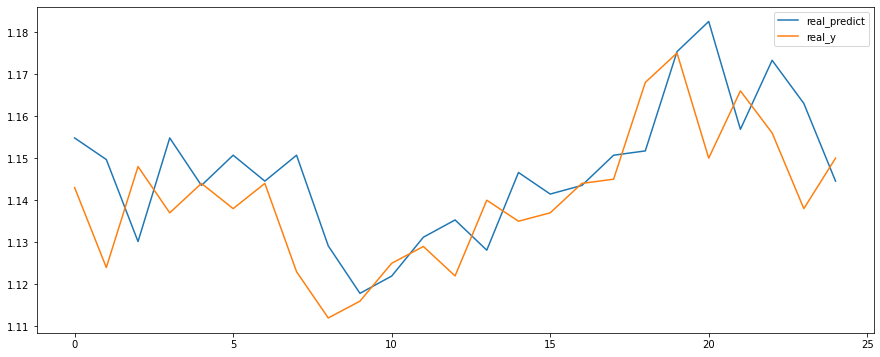

In [69]:
plt.figure(figsize=(15,6))
bwith = 0.75 #边框宽度设置为2
ax = plt.gca()#获取边框
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
plt.plot(c,label='real_predict')
plt.plot(b,label='real_y')
#plt.plot(real_y*(1+0.15),label='15%上限',linestyle='--',color='green')
#plt.plot(b*(1+0.1),label='10%上限',linestyle='--')
#plt.plot(b*(1-0.1),label='10%下限',linestyle='--')
#plt.plot(real_y*(1-0.15),label='15%下限',linestyle='--',color='green')
#plt.fill_between(range(0,12),b*(1+0.15),b*(1-0.15),color='gray',alpha=0.2)
plt.legend()
plt.show()

In [17]:
b=scaler.inverse_transform(b)
c=scaler.inverse_transform(c)
b=b[:,-1]
c=c[:,-1]

In [18]:
b

array([1.189, 1.189, 1.22 , 1.219, 1.235, 1.227, 1.24 , 1.213, 1.188,
       1.205, 1.209, 1.21 , 1.199, 1.198, 1.185, 1.199, 1.219, 1.22 ,
       1.217, 1.219, 1.189, 1.206, 1.211, 1.206, 1.209])